# **Spam Email Detection Using Deep Learning**

### **Introduction**

Spam email detection is a vital application in modern communication systems. As email is one of the most widely used forms of communication, distinguishing between legitimate (ham) emails and unsolicited (spam) messages is essential for protecting users from phishing, scams, and other malicious content. In this project, we develop a spam email detection system using natural language processing (NLP) and deep learning techniques.

### **Objective**

The primary objective of this project is to classify emails as either "ham" (legitimate) or "spam" (unwanted). We utilize the Enron dataset, which contains a collection of emails labeled as "ham" or "spam", making it ideal for supervised learning approaches.

### **Dataset**

The Enron dataset contains several folders labeled "enron1" through "enron6". Each of these folders contains subdirectories for:
- **Ham**: Legitimate emails
- **Spam**: Unwanted emails

We load and process these emails, preparing them for training and evaluation by our deep learning model.

### **Methodology**

The approach we follow includes the following steps:

1. **Data Loading and Preprocessing**:
   - We read each email file, assign it a label ("ham" or "spam"), and load the content into a DataFrame.
   - Text preprocessing is performed, including cleaning, tokenization, and padding to ensure uniform input length.

2. **Exploratory Data Analysis (EDA)**:
   - Basic analysis to understand the distribution of ham and spam emails, average text length, and common words in each category.
   - Visualizations, including word clouds and frequency plots, reveal patterns in the text.

3. **Embedding Layer with Pre-trained GloVe**:
   - We use pre-trained GloVe embeddings (`glove.6B.100d.txt`) to represent each word in a 100-dimensional vector space, leveraging external knowledge from large text corpora.

4. **Model Architecture**:
   - A neural network with a bi-directional LSTM layer is built to capture sequential patterns.
   - The model is trained to classify emails as "ham" or "spam".

5. **Multi-GPU Training**:
   - We use `torch.nn.DataParallel` to distribute training across multiple GPUs, enabling faster training on large datasets.

6. **Evaluation**:
   - The model is evaluated using accuracy, precision, recall, and a confusion matrix to assess its performance on unseen data.

7. **Saving and Inference**:
   - The trained model and vocabulary are saved for future inference, allowing us to make predictions on new emails.

### **Tools and Libraries**

The following tools and libraries are used throughout the notebook:
- **PyTorch**: For model building, training, and multi-GPU support.
- **Pandas and NumPy**: For data handling and manipulation.
- **NLTK and GloVe**: For text preprocessing and embedding generation.
- **Matplotlib and Seaborn**: For data visualization and EDA.

#  Import Required Libraries
- **Data Loading & Preprocessing**: Libraries like `os`, `re`, `nltk`, and `sklearn` help in reading files, cleaning text data, and splitting datasets.
- **Visualization**: `matplotlib`, `seaborn`, and `wordcloud` are for creating plots to visualize patterns in text data.
- **PyTorch**: `torch` and its submodules handle building and training the neural network on multi-GPU if available.

Run this cell to ensure all necessary libraries are loaded. Let me know when you're ready for the next step, which involves loading the email dataset from the directories (`ham` and `spam`).

In [1]:
# For data manipulation and loading
import os
import pandas as pd
import numpy as np
import re
from collections import Counter

# For text preprocessing and tokenization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# PyTorch for model building and multi-GPU support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import one_hot
from sklearn.metrics import confusion_matrix, classification_report

# For encoding labels
from sklearn.preprocessing import LabelEncoder

# Setting random seed for reproducibility
import random

# Ensure NLTK dependencies are downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load and Label the Dataset
1. `load_emails` funcation: This Funcation iterates through each "enron" folder and, within each, it checks both the "ham" and "spam" folders. Each file in these folders is read, and text is added to a list along iwth its label ("ham" or "spam").
2. DataFrame creation:After loading all emails, the funcation returns a DataFrame with each row contining an email's text and its label.

In [2]:
def load_emails(data_dir):
    """
    Load emails from the dataset directory structure. 
    Each email will be labeled based on its folder ("ham" or "spam").
    
    Parameters:
    - data_dir (str): The base directory where the "enron" directories are stored.
    
    Returns:
    - pd.DataFrame: DataFrame with two columns: 'text' and 'label'.
    """
    emails = []
    labels = []

    # Iterate through each "enron" directory (e.g., enron1, enron2, etc.)
    for enron_folder in os.listdir(data_dir):
        enron_path = os.path.join(data_dir, enron_folder)
        
        # Check if the path is indeed a directory
        if os.path.isdir(enron_path):
            # For each enron subdirectory, look inside "ham" and "spam" folders
            for label in ["ham", "spam"]:
                label_path = os.path.join(enron_path, label)
                
                # Make sure we are in the correct subdirectory
                if os.path.isdir(label_path):
                    # Load each file within the "ham" or "spam" directory
                    for file_name in os.listdir(label_path):
                        file_path = os.path.join(label_path, file_name)
                        
                        # Read the file content
                        with open(file_path, 'r', encoding='latin1') as file:
                            email_text = file.read()
                            emails.append(email_text)
                            labels.append(label)
    
    # Create a DataFrame with text and label columns
    data = pd.DataFrame({
        'text': emails,
        'label': labels
    })
    
    return data

In [3]:
# Specify the directory where the "enron-spam" data is stored
data_dir = '/kaggle/input/enron-spam'  # Update this path to your dataset location

# Load the dataset
email_data = load_emails(data_dir)

# Display the first few rows of the loaded data
email_data.head()

,text,label
0,"Subject: fw : ena ctrc ' s\nfyi , kim .\n- - -...",ham
1,Subject: el paso order on complaint\nattached ...,ham
2,Subject: et & s organizational announcement\ni...,ham
3,Subject: board nominations and annual meeting ...,ham
4,Subject: jeff makes the cover of businessweek\...,ham


# Exploratory Data Analysis (EDA)
1. **View Label Distribution**: Check the number of "ham" and "spam" emails to understand if the dataset is balanced.
2. **Analyze Text Length**: Compare the text length of "ham" vs. "spam" emails.
3. **Most Common Words**: Create word clouds to visualize the most common words in each category.
4. **Plot Word Frequency**: Show the frequency distribution of words in each category, excluding common stop words.

### View Label Distribution

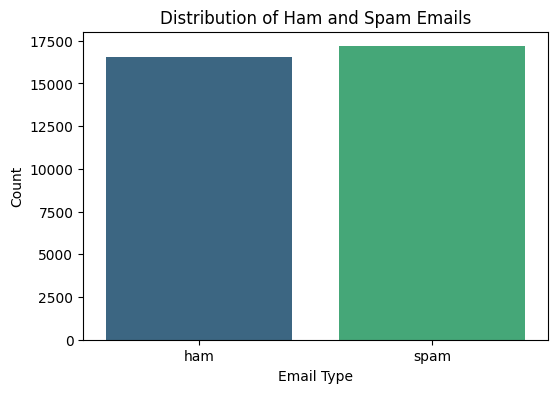

In [4]:
# Count the number of "ham" and "spam" emails
plt.figure(figsize=(6, 4))
sns.countplot(data=email_data, x='label', palette="viridis")
plt.title("Distribution of Ham and Spam Emails")
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.show()

### Analyze Text Lenght

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

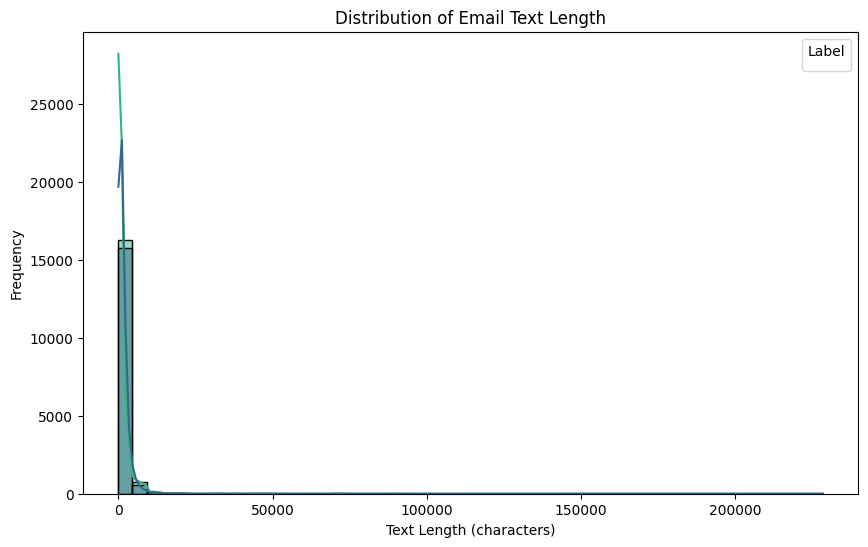

In [5]:
# Calculate the length of each email
email_data['text_length'] = email_data['text'].apply(len)

# Plot distribution of text lengths for ham and spam emails
plt.figure(figsize=(10, 6))
sns.histplot(data=email_data, x='text_length', hue='label', bins=50, kde=True, palette="viridis")
plt.title("Distribution of Email Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.legend(title='Label')
plt.show()

### Most Common Words Using Words Using Word Clouds

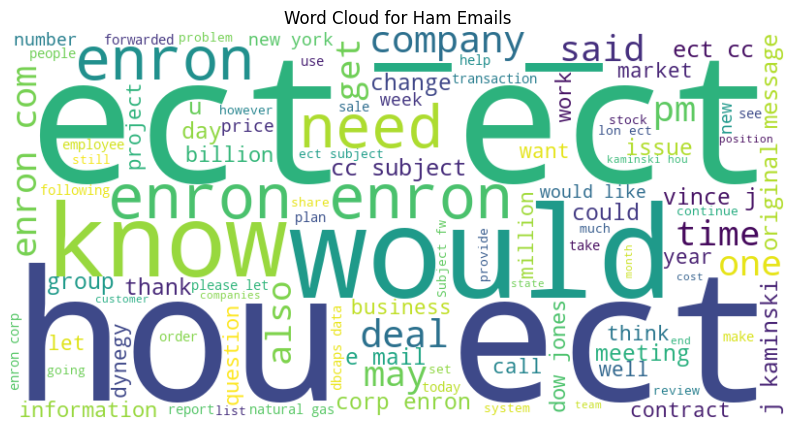

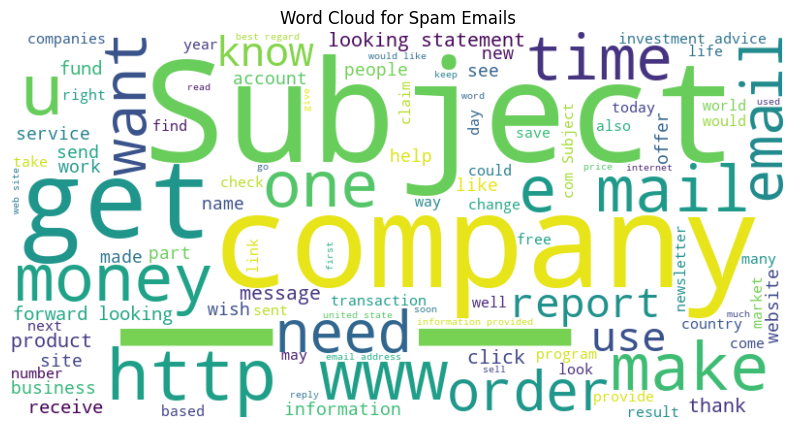

In [6]:
# Get stop words
stop_words = set(stopwords.words('english'))

def generate_wordcloud(data, title):
    text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for ham and spam emails separately
generate_wordcloud(email_data[email_data['label'] == 'ham']['text'], 'Word Cloud for Ham Emails')
generate_wordcloud(email_data[email_data['label'] == 'spam']['text'], 'Word Cloud for Spam Emails')

### Plot Word Frequency Distribution

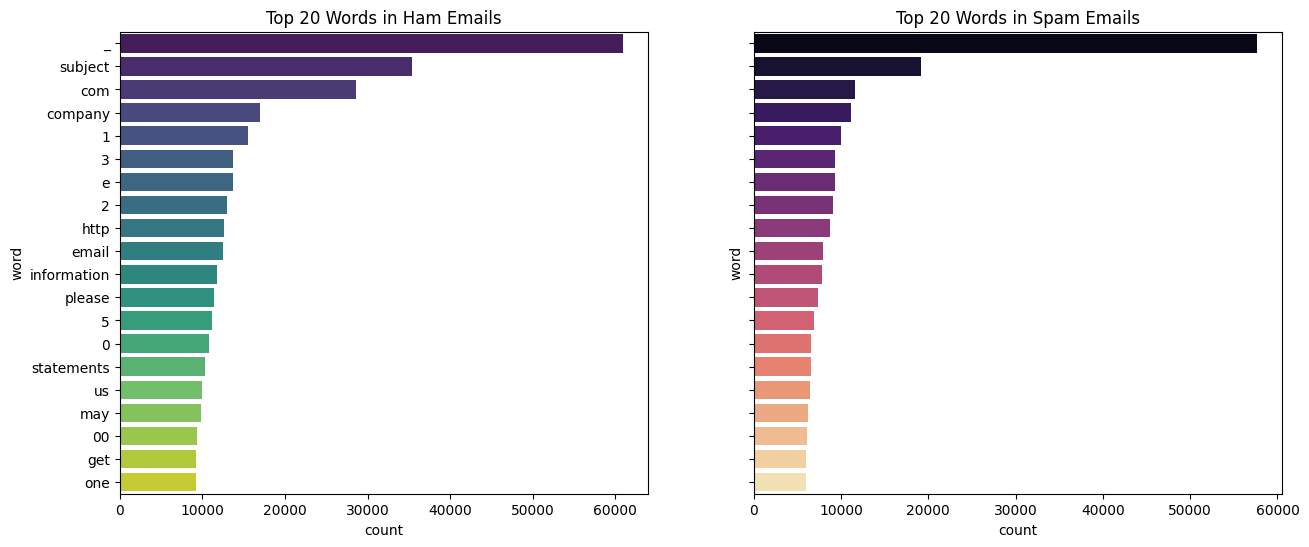

In [7]:
# Helper function to preprocess text
def preprocess_text(text):
    # Remove special characters, make lowercase, and tokenize
    words = re.findall(r'\b\w+\b', text.lower())
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    return words

# Get word frequency for ham and spam emails
ham_words = preprocess_text(' '.join(email_data[email_data['label'] == 'ham']['text']))
spam_words = preprocess_text(' '.join(email_data[email_data['label'] == 'spam']['text']))

# Most common words in ham and spam
ham_common_words = Counter(ham_words).most_common(20)
spam_common_words = Counter(spam_words).most_common(20)

# Convert to DataFrame for visualization
ham_df = pd.DataFrame(ham_common_words, columns=['word', 'count'])
spam_df = pd.DataFrame(spam_common_words, columns=['word', 'count'])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.barplot(data=ham_df, x='count', y='word', ax=axes[0], palette="viridis")
axes[0].set_title("Top 20 Words in Ham Emails")
sns.barplot(data=spam_df, x='count', y='word', ax=axes[1], palette="magma")
axes[1].set_title("Top 20 Words in Spam Emails")
plt.show()

# Data Preprocessing
1. Clean the Text: Remove special characters, convert to lowercase, and tokenize the text.
2. Remove Stop Words: Remove common English words that don’t carry much meaning (e.g., "the", "is").
3. Encode Labels: Convert "ham" and "spam" labels to numerical values.
4. Tokenize Text: Convert each email to a sequence of word indices based on a vocabulary.
5. Padding Sequences: Pad the tokenized sequences to ensure uniform input length for the model.

### 1. Clean and preprocess the text


In [8]:
def preprocess_text(text):
    """
    Cleans the text by removing special characters, converting to lowercase,
    and removing stopwords.
    """
    # Remove special characters and digits, make lowercase, and split by words
    words = re.findall(r'\b\w+\b', text.lower())
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return words

# Apply preprocessing to each email in the dataset
email_data['processed_text'] = email_data['text'].apply(preprocess_text)

### 2. Encode labels

In [9]:
label_encoder = LabelEncoder()
email_data['label_encoded'] = label_encoder.fit_transform(email_data['label'])

### 3. Build a vocabulary and convert words to indices


In [10]:
# Flatten all words in the dataset to count frequencies
all_words = [word for email in email_data['processed_text'] for word in email]
word_counts = Counter(all_words)

# Select the top words for the vocabulary
vocab_size = 10000  # Set the vocabulary size limit
most_common_words = word_counts.most_common(vocab_size - 1)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(most_common_words)}
vocab['<UNK>'] = 0  # Use index 0 for unknown words

# Helper function to convert words in an email to their indices
def words_to_indices(words):
    return [vocab.get(word, vocab['<UNK>']) for word in words]

# Convert processed text to sequences of word indices
email_data['text_indices'] = email_data['processed_text'].apply(words_to_indices)

### 4. Pad sequences to the same length

In [11]:
# Define a maximum sequence length (based on dataset insights)
max_seq_length = 1000  # Adjust this as needed based on EDA

def pad_sequences(sequence):
    if len(sequence) > max_seq_length:
        return sequence[:max_seq_length]
    else:
        return sequence + [0] * (max_seq_length - len(sequence))

email_data['padded_indices'] = email_data['text_indices'].apply(pad_sequences)

# Display the processed data for verification
email_data[['text', 'processed_text', 'label', 'label_encoded', 'text_indices', 'padded_indices']].head()

,text,processed_text,label,label_encoded,text_indices,padded_indices
0,"Subject: fw : ena ctrc ' s\nfyi , kim .\n- - -...","[subject, fw, ena, ctrc, fyi, kim, original, m...",ham,0,"[3, 348, 357, 0, 881, 1675, 117, 36, 6688, 572...","[3, 348, 357, 0, 881, 1675, 117, 36, 6688, 572..."
1,Subject: el paso order on complaint\nattached ...,"[subject, el, paso, order, complaint, attached...",ham,0,"[3, 441, 1017, 104, 5994, 150, 1072, 441, 1017...","[3, 441, 1017, 104, 5994, 150, 1072, 441, 1017..."
2,Subject: et & s organizational announcement\ni...,"[subject, et, organizational, announcement, pl...",ham,0,"[3, 393, 3500, 1370, 1306, 2021, 4667, 0, 2947...","[3, 393, 3500, 1370, 1306, 2021, 4667, 0, 2947..."
3,Subject: board nominations and annual meeting ...,"[subject, board, nominations, annual, meeting,...",ham,0,"[3, 485, 2914, 1150, 119, 20, 0, 2914, 4206, 4...","[3, 485, 2914, 1150, 119, 20, 0, 2914, 4206, 4..."
4,Subject: jeff makes the cover of businessweek\...,"[subject, jeff, makes, cover, businessweek, su...",ham,0,"[3, 512, 1119, 982, 9727, 398, 3160, 1584, 333...","[3, 512, 1119, 982, 9727, 398, 3160, 1584, 333..."


# Dataset and DataLoader Setup
1. Define a Custom Dataset: The `EmailDataset` class will inherit from PyTorch’s `Dataset` and allow easy access to each email’s input (padded indices) and label.
2. Initialize DataLoader: We’ll use a `DataLoader` to handle batching, shuffling, and loading data for training and testing.

### 1. Custom Dataset for Email Data

In [12]:
class EmailDataset(Dataset):
    def __init__(self, data):
        """
        Initializes the EmailDataset.
        
        Parameters:
        - data (DataFrame): Preprocessed email data with columns 'padded_indices' and 'label_encoded'.
        """
        self.data = data
        self.texts = data['padded_indices'].values
        self.labels = data['label_encoded'].values

    def __len__(self):
        # Return the total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get the text indices and label for a specific index
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label

### 2. Split data into training and test sets

In [13]:
# Using an 80-20 split for training and testing
train_data, test_data = train_test_split(email_data, test_size=0.2, random_state=42, stratify=email_data['label_encoded'])


### 3. Create Dataset and DataLoader for training and testing

In [14]:
batch_size = 64  # Define an appropriate batch size

# Training and testing datasets
train_dataset = EmailDataset(train_data)
test_dataset = EmailDataset(test_data)

# Training and testing dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display the first batch for verification
first_batch = next(iter(train_loader))
print("Sample batch text indices:", first_batch[0].shape)  # Shape should be (batch_size, max_seq_length)
print("Sample batch labels:", first_batch[1].shape)  # Shape should be (batch_size,)

Sample batch text indices: torch.Size([64, 1000])
Sample batch labels: torch.Size([64])


# Model Building
we'll build a spam detection model using a pre-trained embedding layer from GloVe. We’ll load this embedding into our model to leverage semantic information from a large corpus of text, which can help improve classification accuracy.

### 1. Load GloVe Embeddings

In [15]:
# Path to the GloVe embeddings file
glove_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'

# Load the GloVe embeddings
def load_glove_embeddings(glove_path, vocab, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(vocab), embedding_dim))  # Random initialization
    with open(glove_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in vocab:
                embeddings[vocab[word]] = vector
    return embeddings

In [16]:
# Load embeddings and convert to a tensor
embedding_dim = 100
glove_embeddings = load_glove_embeddings(glove_path, vocab, embedding_dim)
embedding_matrix = torch.tensor(glove_embeddings, dtype=torch.float)

### 2. Define the Model Architecture
We'll create a simple nerual network with:
- An embedding layer initialized with the GloVe embeddings (set as non_trainable).
- A bi-eirectional LSTM to capture sequential patterns in the email text.
- Fully connected layers for classification.

In [17]:
class SpamClassifierModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim):
        super(SpamClassifierModel, self).__init__()
        
        # Embedding layer with pre-trained GloVe embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, 
                            num_layers=1, batch_first=True, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # hidden_dim * 2 because of bidirectional
        
        # Softmax activation for classification
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)
        
        # Pass through LSTM
        _, (hidden, _) = self.lstm(embedded)
        
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        
        # Fully connected layer and softmax for classification
        output = self.fc(hidden)
        return self.softmax(output)

In [18]:
# Model parameters
hidden_dim = 128
output_dim = 2  # Two classes: ham and spam

# Initialize the model
model = SpamClassifierModel(vocab_size=len(vocab), embedding_dim=embedding_dim, 
                            embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, 
                            output_dim=output_dim)

# Multi-GPU support if available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.cuda() if torch.cuda.is_available() else model

print(model)

DataParallel(
  (module): SpamClassifierModel(
    (embedding): Embedding(10000, 100)
    (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=256, out_features=2, bias=True)
    (softmax): Softmax(dim=1)
  )
)


# Training Setup

### 1. Define Loss Funcation and Optimizer
We'll use `CrossEntropyLoss` since it's suitable for multi-class classification tasks, and `Adm` as optimizer.

In [19]:
# Loss funcation and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 2. Training Loop with Multi-GPU Support
In the training Loop:
- We'll move batchs of data to the GPU(or multiple GPU) for faster processing.
- We'll also log loss and accuracy to monitor performance.

In [20]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Loop over epochs
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        # Loop over batches
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        # Print average loss and accuracy for the epoch
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

In [21]:
# Set the number of epochs
num_epochs = 20

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/20], Loss: 0.4913, Accuracy: 0.8204
Epoch [2/20], Loss: 0.6025, Accuracy: 0.7104
Epoch [3/20], Loss: 0.8039, Accuracy: 0.5093
Epoch [4/20], Loss: 0.8039, Accuracy: 0.5093
Epoch [5/20], Loss: 0.4829, Accuracy: 0.8267
Epoch [6/20], Loss: 0.3536, Accuracy: 0.9588
Epoch [7/20], Loss: 0.3408, Accuracy: 0.9722
Epoch [8/20], Loss: 0.3373, Accuracy: 0.9752
Epoch [9/20], Loss: 0.3342, Accuracy: 0.9784
Epoch [10/20], Loss: 0.3326, Accuracy: 0.9808
Epoch [11/20], Loss: 0.3315, Accuracy: 0.9814
Epoch [12/20], Loss: 0.3271, Accuracy: 0.9864
Epoch [13/20], Loss: 0.3273, Accuracy: 0.9859
Epoch [14/20], Loss: 0.3272, Accuracy: 0.9858
Epoch [15/20], Loss: 0.3265, Accuracy: 0.9867
Epoch [16/20], Loss: 0.3248, Accuracy: 0.9887
Epoch [17/20], Loss: 0.3243, Accuracy: 0.9889
Epoch [18/20], Loss: 0.3221, Accuracy: 0.9912
Epoch [19/20], Loss: 0.3229, Accuracy: 0.9904
Epoch [20/20], Loss: 0.3241, Accuracy: 0.9892


# Evaluation

In [22]:
def evaluate_model(model, test_loader, criterion):
    # Set model to evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Store labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['Ham', 'Spam']))

    # Plot confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Test Loss: 0.3568
Test Accuracy: 0.9568

Classification Report:
              precision    recall  f1-score   support

         Ham       0.94      0.98      0.96      3309
        Spam       0.98      0.94      0.96      3434

    accuracy                           0.96      6743
   macro avg       0.96      0.96      0.96      6743
weighted avg       0.96      0.96      0.96      6743



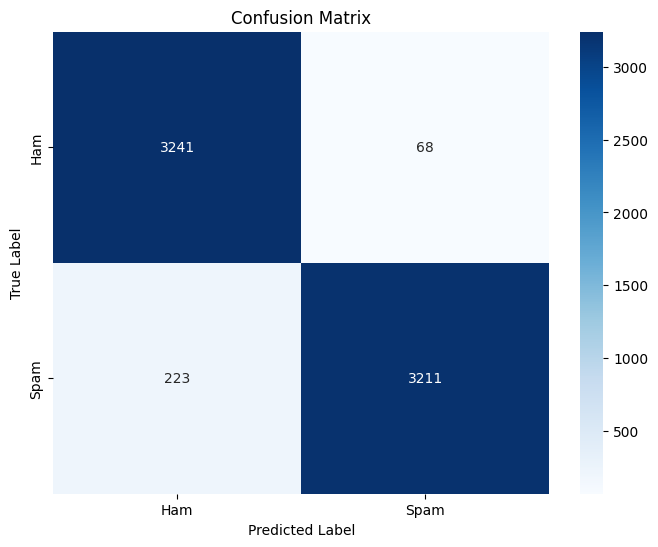

In [23]:
# Evaluate the model on the test set
evaluate_model(model, test_loader, criterion)

# Make Predictions on New Data:
Define a function to predict whether new emails are "spam" or "ham".


In [24]:
def preprocess_and_tokenize(text, vocab, max_seq_length=300):
    # Preprocess and tokenize text
    words = preprocess_text(text)
    indices = [vocab.get(word, vocab['<UNK>']) for word in words]
    
    # Pad or truncate to the specified max sequence length
    if len(indices) < max_seq_length:
        indices.extend([0] * (max_seq_length - len(indices)))
    else:
        indices = indices[:max_seq_length]
    
    # Convert to tensor
    return torch.tensor(indices, dtype=torch.long).unsqueeze(0)  # Adding batch dimension

def predict_email(model, email_text, vocab):
    # Set model to evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Preprocess and tokenize input text
    input_tensor = preprocess_and_tokenize(email_text, vocab).to(device)
    
    # Perform prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        return "Ham" if predicted.item() == 0 else "Spam"

# Example usage
sample_email = "Congratulations! You've won a free ticket to Bahamas. Claim now!"
print("Prediction:", predict_email(model, sample_email, vocab))

Prediction: Spam


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


# Save the Model

In [25]:
# Save the model's state_dict
model_save_path = 'spam_classifier_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to spam_classifier_model.pth


# Save the Tokenizer (Vocabulary)

In [26]:
import json

# Save vocabulary as a JSON file
vocab_save_path = 'vocab.json'
with open(vocab_save_path, 'w') as vocab_file:
    json.dump(vocab, vocab_file)
print(f"Vocabulary saved to {vocab_save_path}")

Vocabulary saved to vocab.json


### **Conclusion**

By the end of this notebook, we will have built and evaluated a robust spam email classifier capable of distinguishing between "ham" and "spam" emails. This model can be applied to email filtering systems, enhancing user security and improving inbox organization.